# Decision trees & random forests
The aim of this tutorial is to get familiar with the use of decision trees and their generalizations on simple examples using `scikit-learn` tools.

## Gradient Boosted Decision Trees (GBDT)

## Completing your installation first
You will need to install packages `python-graphviz` first. If needed, uncomment the `conda` command below:

In [379]:
from mlxtend.plotting import plot_decision_regions
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Load the library with the iris dataset
from sklearn.datasets import load_iris, load_wine
# Load scikit's decision tree classifier
from sklearn import tree
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# To visualize trees
import graphviz 
# Load pandas to manipulate data frames (Excel like)
import pandas as pd
# Set random seed
np.random.seed(0)
import warnings 
warnings.filterwarnings("ignore")

The data for this tutorial is famous. Called, **the iris dataset**, it contains four variables measuring various parts of iris flowers of three related species, and then a fourth variable with the species name. The reason it is so famous in machine learning and statistics communities is because the data requires very little preprocessing (i.e. no missing values, all features are floating numbers, etc.).

In [380]:
iris = load_iris()

## Step 1: explore the data set

### <font color=blue>1. What is the structure of the object `iris` ?</font>

In [381]:
# When loged, the structure of "iris" is a dictionnary with the keys given below :
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

<font color='#0031'> Each node of "iris" contains specific informations :
* data : Sample of data (with the features only and without the target value)
* DESCR : A full description of the data (Number of attributes, Summary Statistics, References ...)
* feature_names : The associated name of the features in the data (Input propreties of the flowers)
* target_names : The associated explanatory name with the targets (names of the flowers) 
* filename : The local path of the data file (.csv). 

### <font color=blue>2. Plot this dataset in a well chosen set of representations to explore the data.</font>

## Using `pandas` to manipulate the data
Pandas is great to manipulate data in a Microsoft Excel like way.

In [382]:
import pandas as pd

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [383]:
# Add a new column with the species names, this is what we are going to try to predict
df['species'] = pd.Categorical.from_codes(codes=iris.target, categories=iris.target_names,ordered=True)

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Till we have a multivariate data, a common way of visualizing it is throughout the **Parallel coordinates**.

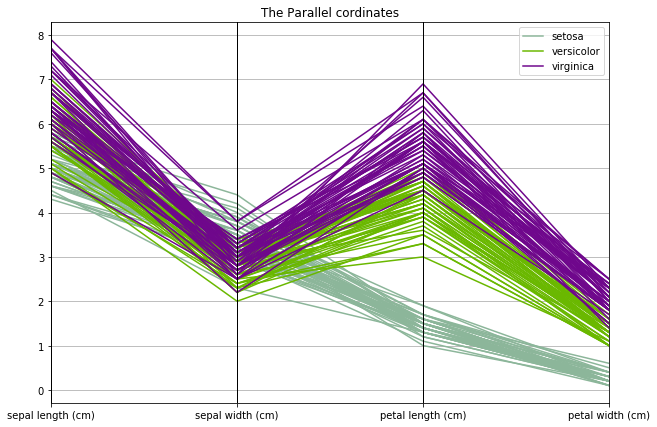

In [384]:
# Plotting the Parallel Cordinates of the the data
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(10,7))
parallel_coordinates(df, 'species')
plt.title("The Parallel cordinates")
plt.show()

<font color='#000080'> We can already have some useful interpretation of the resulting figure :
* The targets have clear discriminate sets of values when it comes to the **petal** features, while it's completely the opposite with the **sepal** features, where the data points have clear interval intersections. 
Therefore, we can already interpet that by the penal features being more discriminative of the targets. Thus, our upcoming approach with the decision trees will have a usefull use of those features.

According to the above note, an intuitive descriptive representation would be the corrlation between the features and the target since we noticed a discriminative aspect of some features :

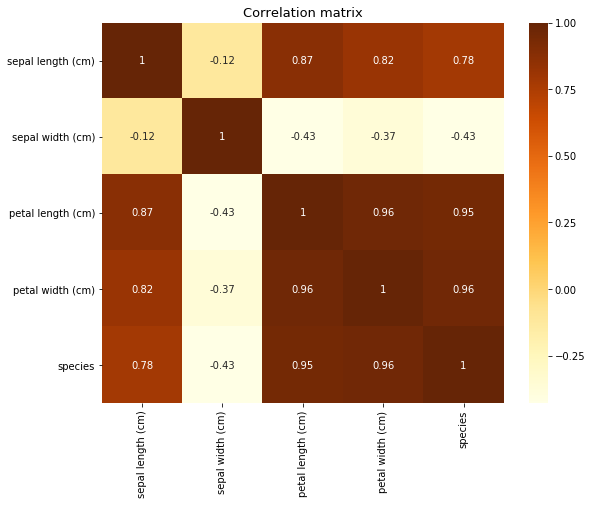

In [385]:
import seaborn as sns # we use seaborn to plot the correlation matrix
from sklearn.preprocessing import LabelEncoder # This one is used to encode the target values to their equivalent integer values
                                                # 0,1,2
le=LabelEncoder() # Intanciating the encoder
df["species"]=le.fit_transform(df["species"]) # encoding the target variable
corr=df.corr()# Compute the correlation matrix as a dataframe and 
                # drops the unused features we generated (here "is_train")
plt.figure(figsize=(9,7))
plt.title('Correlation matrix', size=13)
sns.heatmap(corr, annot=True, cmap='YlOrBr')
plt.show()

<font color='#000080'> 
* We clearly notice that the penal are highly correlated with the target (with a value over 95 %).
* As for the **sepal length** is also highly correlated with the target (another look at the previous parallel cordiantes plot show that this feature is also a bit discriminative but not as much as the pena features)
* **sepal width** is decorrelated from the target and the other variables, which confirms a prior knowledge of the non discrimanatory character of this feature.

## Step 2: create training and test sets

Create a new column that for each row, generates a random number between 0 and 1, and if that value is less than or equal to .75, then sets the value of that cell as True and false otherwise. This is a quick and dirty way of randomly assigning some rows to be used as the training data and some as the test data.

In [386]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# View the top 5 rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
0,5.1,3.5,1.4,0.2,0,True
1,4.9,3.0,1.4,0.2,0,True
2,4.7,3.2,1.3,0.2,0,True
3,4.6,3.1,1.5,0.2,0,True
4,5.0,3.6,1.4,0.2,0,True


In [387]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [388]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))
df.groupby('is_train').count()

Number of observations in the training data: 118
Number of observations in the test data: 32


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
is_train,,,,,
False,32,32,32,32,32
True,118,118,118,118,118


In [389]:
# Create a list of the feature column's names
features = df.columns[:4]

# View features
features

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [390]:
# note that train['species'] contains the digits, since we encoded the categorical variables when we 
# prepared data to make the correlation matrix
y = train['species']

## Step 3: decision trees for the iris dataset
The method `tree.DecisionTreeClassifier()` from `scikit-learn` builds decision trees objects as follows:

In [397]:
clf = tree.DecisionTreeClassifier()
# Using the hwole dataset you may use directly:
clf = clf.fit(iris.data, iris.target)

# Using the training dataset :
# clf = clf.fit(train["features"], y)

The `export_graphviz` exporter supports a variety of aesthetic options, including coloring nodes by their class (or value for regression) and using explicit variable and class names if desired. Jupyter notebooks also render these plots inline automatically:

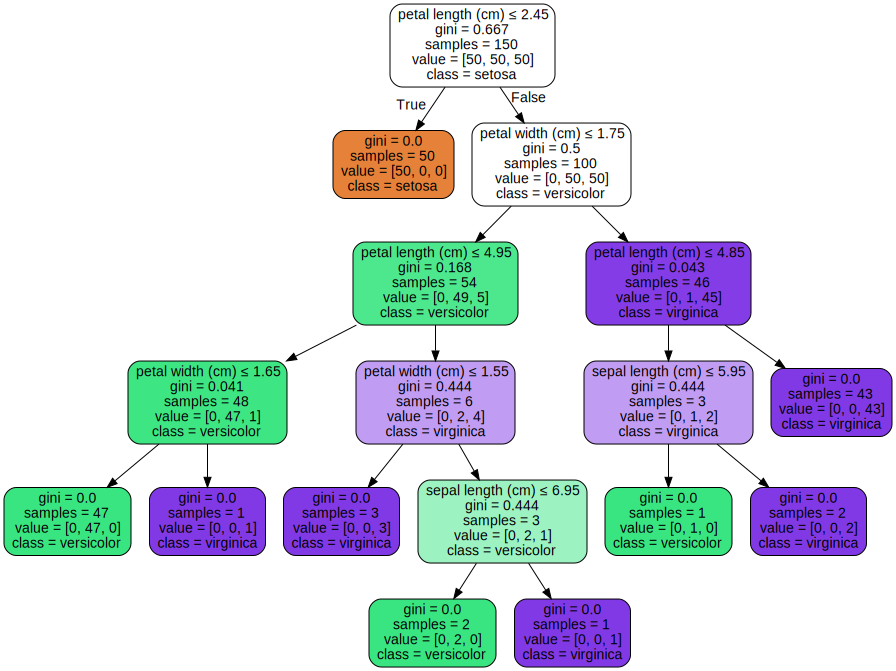

In [398]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph  

We can also export the tree in Graphviz format and  savethe resulting graph in an output file iris.pdf:

In [394]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

In [399]:
test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,is_train
7,5.0,3.4,1.5,0.2,0,False
8,4.4,2.9,1.4,0.2,0,False
10,5.4,3.7,1.5,0.2,0,False
13,4.3,3.0,1.1,0.1,0,False
17,5.1,3.5,1.4,0.3,0,False


After being fitted, **the model can then be used to predict the class of samples**:

In [400]:
test_pred = clf.predict(test[features])
y_test=pd.factorize(test['species'])[0]
# Compute the 0-1 loss for the test set
print("The test error is : {} %".format((1-clf.score(test[features], y_test))*100))

The test error is : 0.0 %


## Exercise 1
1. Train the decision tree on the iris dataset and explain how one should read blocks in `graphviz` representation of the tree.

2. Plot the regions of decision with the points of the training set superimposed.

*Indication: you may find the function `plt.contourf` useful.

#### <font color=blue>1. Train the decision tree on the iris dataset and explain how one should read blocks in `graphviz` representation of the tree.</font>

<font color='#000080'> To read the graphviz blocks, the reader should know that :
* The decision tree has to be read from the top : at each node, there is a condition and either it's validated or not. The left children nodes satisfy parents criterion, while the right ones don't.
* All non-leaf nodes dispaly information in this order from the top:
    * The threshold criterion on a feature used for classification on the node.
    * The value on the node of the method used to compute nodes impurity using a gain method (defaulted to the "Gini" but there is also the "entropy" method.)
    * **Value**, which is a list indexed by the targets classes with population on each class in the given node.
    * **Class** is the dominant class with the largest population.
* In the current dataset, all the leafs have a unique remaining class, which eliminates the need for a majority vote when getting to a leaf node. In a more general wase, we will be supposed to have a majority vote (or use the classes frequencies probability distribution generator) when we apply conditions on the deepth of the tree for example.

In [401]:
# This function sum up the generation of the train and test sets from the data 
# Takes the train size as a parameter a returns the train and test sets
def set_train_test(train_size=0.75):
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= train_size
    train, test = df[df['is_train']==True].drop(["is_train"], axis=1), df[df['is_train']==False].drop(["is_train"], axis=1)
    return train, test

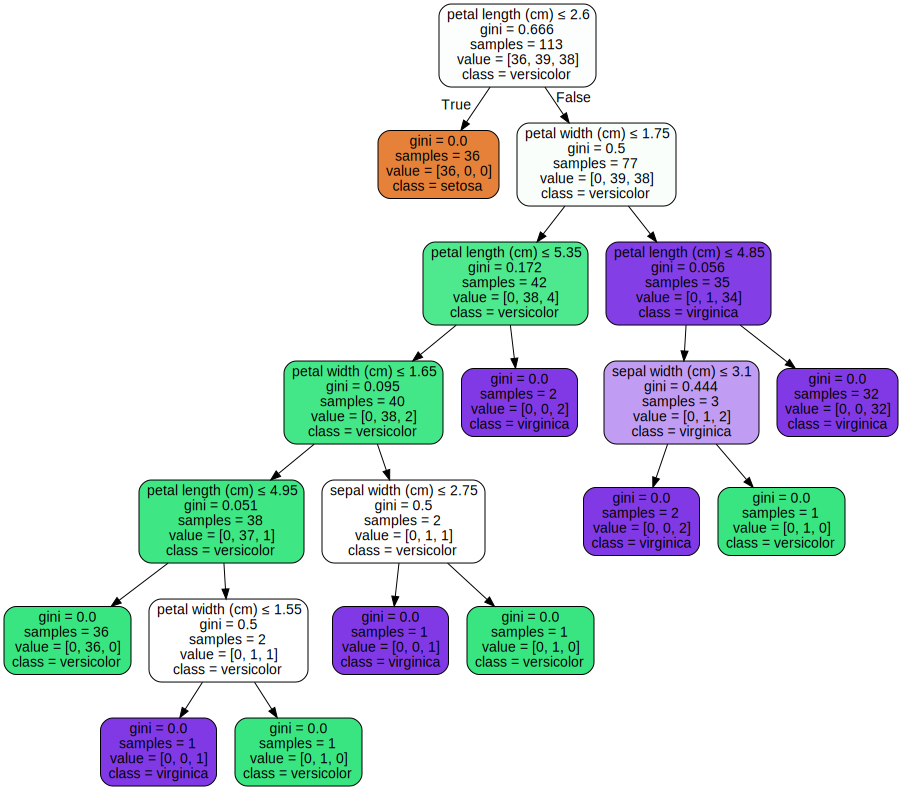

In [403]:
# set the train and test sets
train, test=set_train_test()
# retrieve the target of all data points
y = train['species']
# load and fir a decision tree on the whole data
clf = tree.DecisionTreeClassifier(criterion="gini")
clf = clf.fit(train.iloc[:,:4], y)

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True, proportion=False,  
                         special_characters=True, impurity=True)  
graph = graphviz.Source(dot_data)  
graph 

In [407]:
# Using cross validation to approximate the decision tree accuracy
from sklearn.model_selection import cross_val_score
cv_error=(1-cross_val_score(clf, iris.data, df["species"], cv=10).mean())*100
print("The cross validation error of the model is", cv_error, "%")

The cross validation error of the model is 4.0000000000000036 %


* <font color='#000080'> We can state that the accuracy of the model is around 96 % and so that the generalization error is small.

In [25]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris_one_epoc") 

'iris_one_epoc.pdf'

#### <font color=blue>2. Plot the regions of decision with the points of the training set superimposed.


<font color='#000080'> In order to be able to plot the decision regions a way of doing it is throughout the principal components we will have when performing a PCA assuming that the the first and the second components accumulate the largest part of the variance.

In [408]:
# Set the train and test sets
train, test = set_train_test(train_size=0.75)

In [461]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_proj=pca.fit_transform(train.iloc[:,:4].values, train['species'].values)
test_proj=pca.transform(test.iloc[:,:4].values)

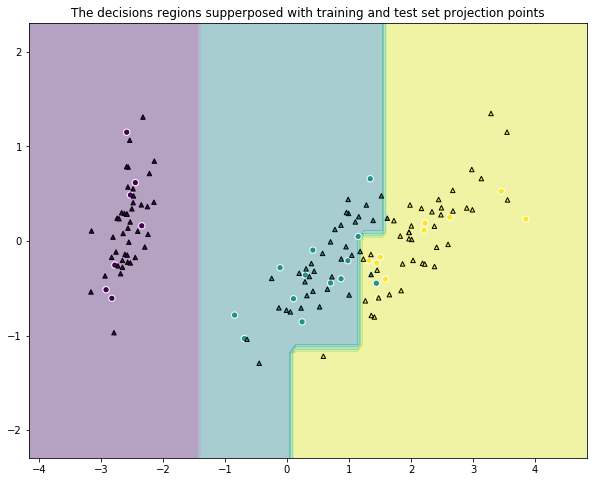

In [463]:
# Plotting decision regions
X_train, X_test=train_proj, test_proj
y_train, y_test=train['species'].values, test['species'].values

clf = tree.DecisionTreeClassifier(criterion="gini")
clf.fit(X_train, y_train)
x_min, x_max = min(X_test[:, 0].min(), X_train[:, 0].min())  - 1, max(X_test[:, 0].max(), X_train[:, 0].max()) + 1
y_min, y_max = min(X_test[:, 1].min(), X_train[:, 1].min())  - 1, max(X_test[:, 1].max(), X_train[:, 1].max()) + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))
tt='Decision Tree'
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr.contourf(xx, yy, Z, alpha=0.4)
axarr.scatter(X_test[:, 0], X_test[:, 1], c=y_test,s=40, edgecolor='white')
# The training data is highlited with triangles in the figures while the test data in points
axarr.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=20, edgecolor='k', marker="^")
axarr.set_title("The decisions regions supperposed with training and test set projection points")
plt.show()

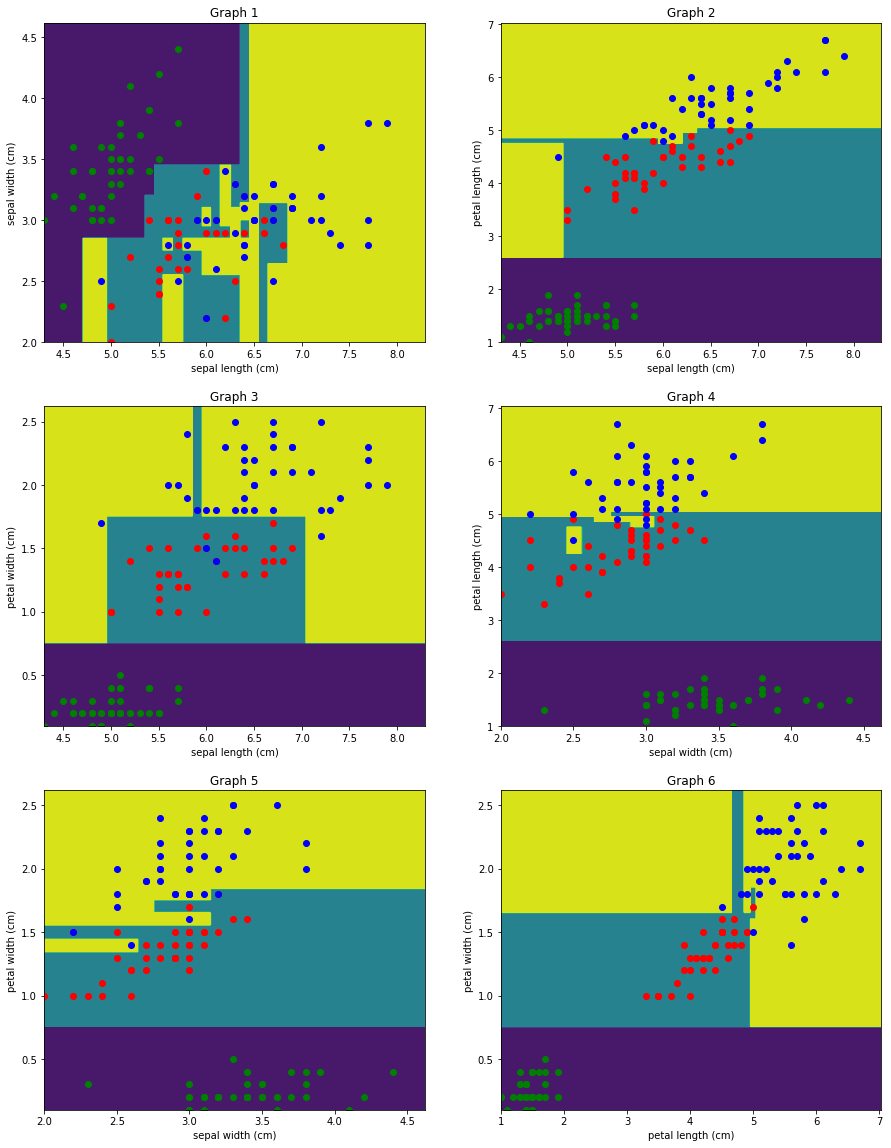

In [464]:
plt.figure(figsize=(15,20))

couples_features = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
i=0
y=train["species"]
for indices in couples_features:
    i+=1
    feature_1, feature_2 = features[indices[0]] ,features[indices[1]]
    
    
    plt.subplot(3,2,i)
    
    #We plot the differents points acording their target value
    plt.plot(list(train[feature_1][y==0].values), list(train[feature_2][y==0].values), "go")
    plt.plot(list(train[feature_1][y==1].values), list(train[feature_2][y==1].values), "ro")
    plt.plot(list(train[feature_1][y==2].values), list(train[feature_2][y==2].values), "bo")
    
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    
    plt.title("Graph "+str(i))
    
    # we get the range of values for each feature in order to create the graph of regions of decision
    range_1 = np.arange(train[feature_1].min(), train[feature_1].max()*1.05, 0.01)
    range_2 = np.arange(train[feature_2].min(), train[feature_2].max()*1.05, 0.01)
    xx,yy = np.meshgrid(range_1, range_2)
    
    
    clf = tree.DecisionTreeClassifier().fit(train[[feature_1,feature_2]], y)
    
    points = np.array([xx.ravel(),yy.ravel()]).T    
    predictions = clf.predict(points)
    plt.contourf(xx,yy, predictions.reshape(xx.shape))


<font color='#000080'>  For the first graph, regions aren't homogoneous : there is space from a region included in another region. It shows that sepal lenght and sepal widht can't discriminate the target class. For the other graphes, we can see that boundaries are logical excpet for 1 or 2 smaples in graphs 2 and 3.

## Exercise 2
1. Build 2 different trees based on a sepal features (sepal lengths, sepal widths) vs petal features (petal lengths, petal widths) only: which features are the most discriminant?

2. Compare performances with those obtained using all features.

3. Try the same as above using the various splitting criterion available, Gini's index, classification error or cross-entropy. Comment on your results. 

#### <font color=blue>1. Build 2 different trees based on a sepal features (sepal lengths, sepal widths) vs petal features (petal lengths, petal widths) only: which features are the most discriminant?


* <font color='#000080'> Training on the features : sepal lengths, sepal widths

In [465]:
# Set the train and test sets for this question
train, test = set_train_test(train_size=0.75)

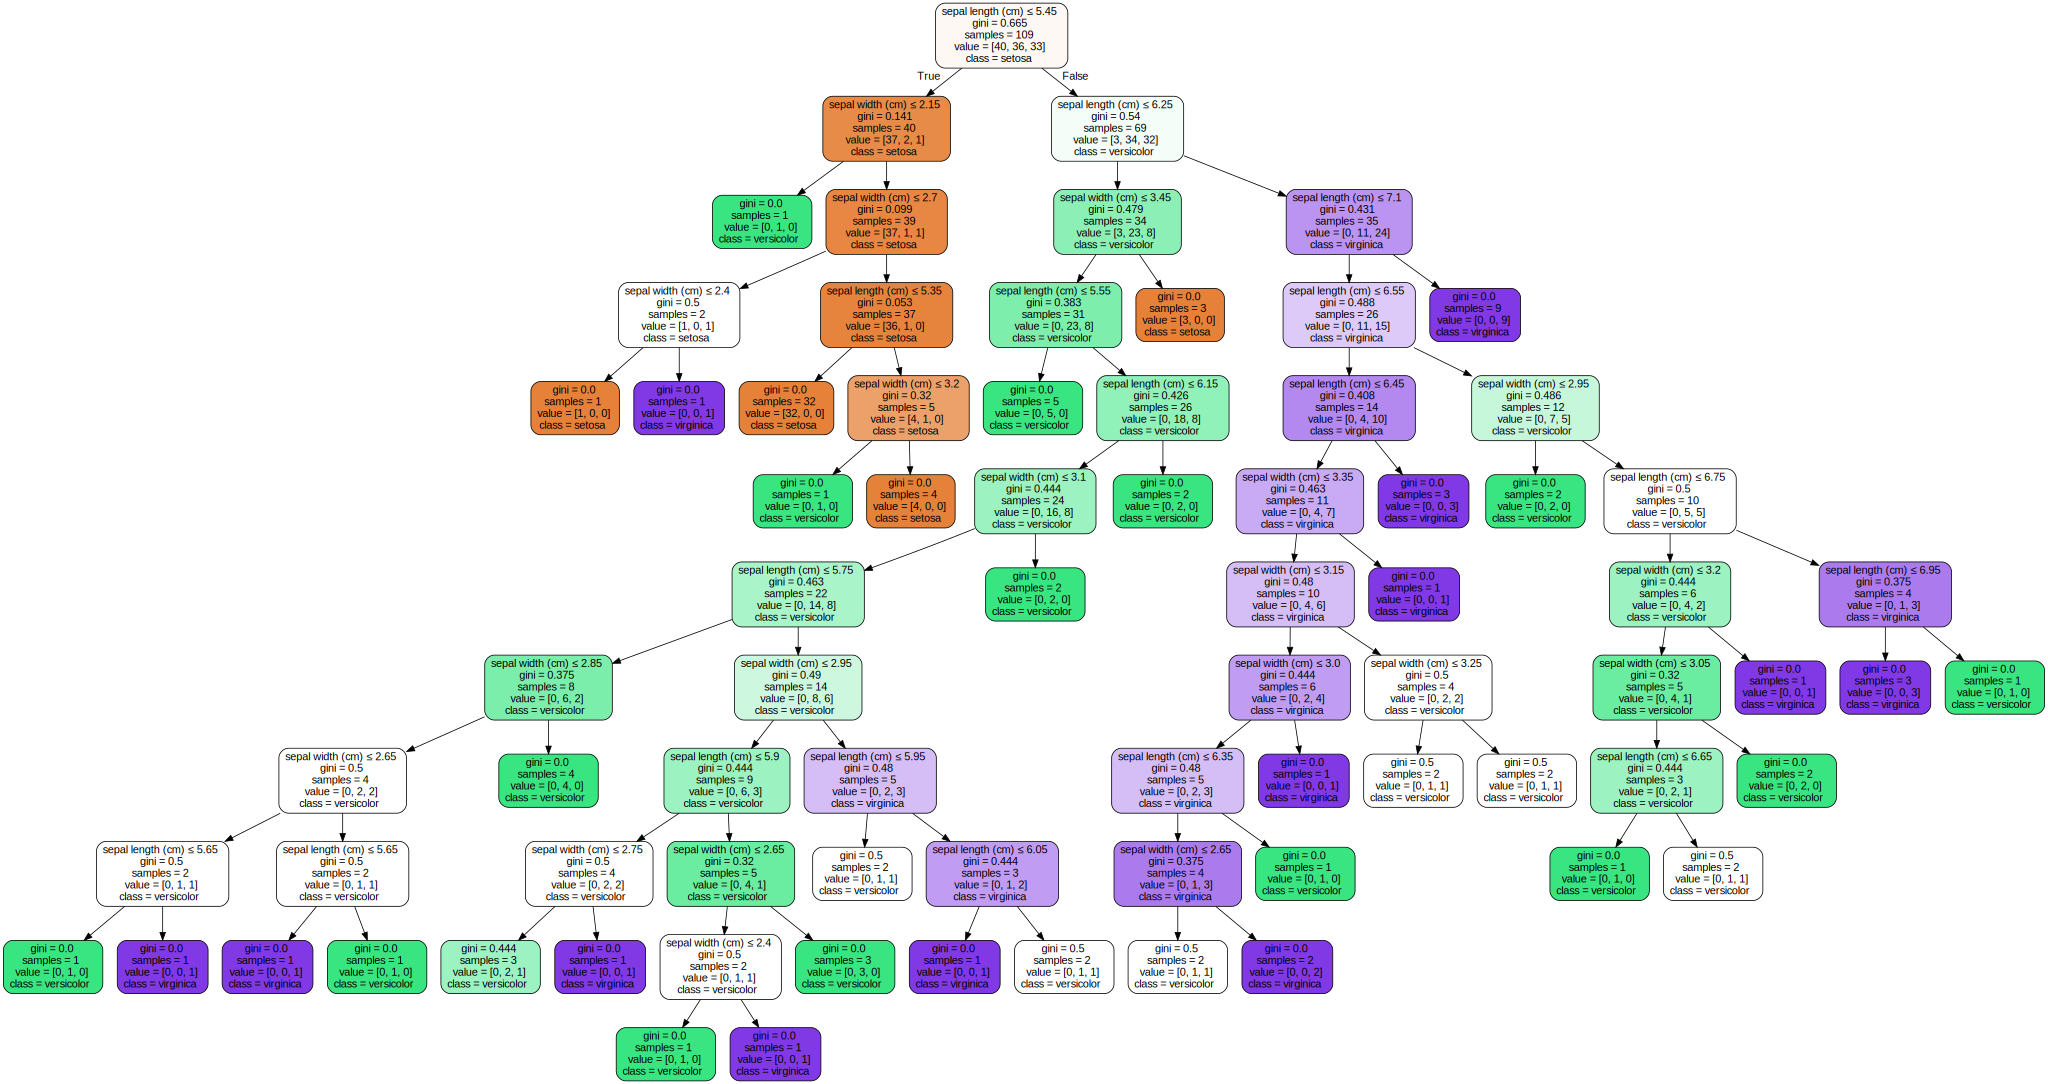

In [466]:
y = train['species']
clf_sepal = tree.DecisionTreeClassifier(criterion="gini")
clf_sepal.fit(train.iloc[:,:2], y)

dot_data = tree.export_graphviz(clf_sepal, out_file=None, 
                         feature_names=iris.feature_names[:2],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True, proportion=False,  
                         special_characters=True, impurity=True)  
graph = graphviz.Source(dot_data)  
graph 

In [467]:
# Using cross validation to approximate the decision tree accuracy
from sklearn.model_selection import cross_val_score
k_folds=10
clf = tree.DecisionTreeClassifier(criterion="gini")
"The mean estimates error with the cross validation (k_folds={k}) over the whole data set is : {err} %".format(err=100*(1-cross_val_score(clf, iris.data[:,:2], df["species"], cv=10).mean()),k=k_folds)

'The mean estimates error with the cross validation (k_folds=10) over the whole data set is : 32.666666666666664 %'

* <font color='#000080'> Training on the features : petal lengths, petal widths

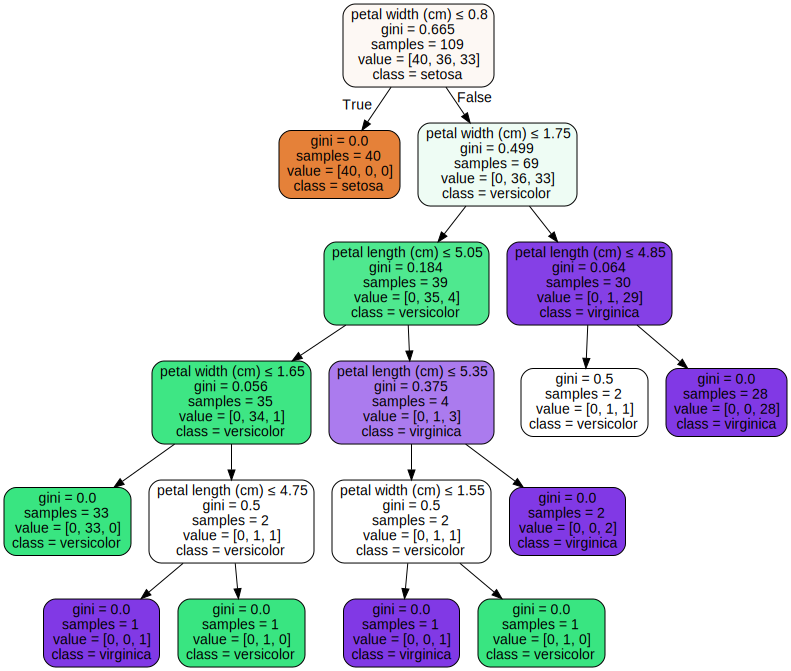

In [468]:
y = train['species']
clf_petal = tree.DecisionTreeClassifier(criterion="gini")
clf_petal.fit(train.iloc[:,2:4], y)

dot_data = tree.export_graphviz(clf_petal, out_file=None, 
                         feature_names=iris.feature_names[2:],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True, proportion=False,  
                         special_characters=True, impurity=True)  
graph = graphviz.Source(dot_data)  
graph 

In [469]:
# Using cross validation to approximate the decision tree accuracy
from sklearn.model_selection import cross_val_score
k_folds=10
clf = tree.DecisionTreeClassifier(criterion="gini")
"The mean estimates error with the cross validation (k_folds={k}) over the whole data set is : {err} %".format(err=100*(1-cross_val_score(clf, iris.data[:,2:], df["species"], cv=10).mean()),k=k_folds)

'The mean estimates error with the cross validation (k_folds=10) over the whole data set is : 5.333333333333334 %'

<font color='#000080'> Comments on the results :
* As qualitatively expected, the model trained on the petal features is a way more accurate than the themodel trained on the sepal features.

#### <font color=blue>2. Compare performances with those obtained using all features.


In [470]:
# Using cross validation to approximate the decision tree accuracy
from sklearn.model_selection import cross_val_score
k_folds=10
clf = tree.DecisionTreeClassifier(criterion="gini")
"The mean estimates error with the cross validation (k_folds={k}) over the whole data set is : {err} %".format(err=100*(1-cross_val_score(clf, iris.data, df["species"], cv=10).mean()),k=k_folds)

'The mean estimates error with the cross validation (k_folds=10) over the whole data set is : 4.0000000000000036 %'

<font color='#000080'> The generalization error is better with the whole feature used for the training of the decision tree.

#### <font color=blue>3. Try the same as above using the various splitting criterion available, Gini's index, classification error or cross-entropy. Comment on your results.


#### <font color='#000080'> Training the model using the entropy gain as a criterion :


In [471]:
# Using cross validation to approximate the decision tree accuracy
from sklearn.model_selection import cross_val_score
k_folds=10
clf = tree.DecisionTreeClassifier(criterion="entropy")
"The mean estimates error with the cross validation (k_folds={k}) over the whole data set is : {err} %".format(err=100*(1-cross_val_score(clf, iris.data[:,:2], df["species"], cv=10).mean()),k=k_folds)

'The mean estimates error with the cross validation (k_folds=10) over the whole data set is : 33.33333333333333 %'

In [472]:
# Using cross validation to approximate the decision tree accuracy
from sklearn.model_selection import cross_val_score
k_folds=10
clf = tree.DecisionTreeClassifier(criterion="entropy")
"The mean estimates error with the cross validation (k_folds={k}) over the whole data set is : {err} %".format(err=100*(1-cross_val_score(clf, iris.data[:,2:], df["species"], cv=10).mean()),k=k_folds)

'The mean estimates error with the cross validation (k_folds=10) over the whole data set is : 5.333333333333334 %'

In [473]:
# Using cross validation to approximate the decision tree accuracy
from sklearn.model_selection import cross_val_score
k_folds=10
clf = tree.DecisionTreeClassifier(criterion="entropy")
"The mean estimates error with the cross validation (k_folds={k}) over the whole data set is : {err} %".format(err=100*(1-cross_val_score(clf, iris.data, df["species"], cv=10).mean()),k=k_folds)

'The mean estimates error with the cross validation (k_folds=10) over the whole data set is : 4.0000000000000036 %'

#### <font color='#000080'> Training the model using the entropy gain as a criterion :
Using the entropy as a new criterion to measure the quality of a split didn't change the result in a significant way. Therefore both criterions have a similar description of the impurity of the spltitting of internal nodes. From now on, we will only use the Gini Index as a criterion for the **iris** data set.

## Step 4: Random forests
Go to 

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

for a documentation about the `RandomForestClassifier` provided by `scikit-learn`.

Since target values must be integers, we first need to transform labels into numbers as below.

In [267]:
# Set the train and test sets for this question
train, test = set_train_test(train_size=0.75)
# remember that we encoded the target
y = train["species"]

* <font color='#000080'>  Random forest classifier has too much parameters to fix. We start, by choosing our train parameters set regarding the following approach considerations :
    * Number of trees (**n_estimators**) : Increasing the number of trees in the forest decreases the variance of the model, and doesn't contribute to overfitting. Therfore the only factor that decides the maximum number of trees is the computational budget.
    * Maximum depth of tree (**max_depth**) : The setting of this parameter avoids the eventual overfitting. So we better choose a small depth, and a better solution will be by tuning the model using the cross validation.
    * Minimum samples for a node split (**min_samples_split** defaulted to 2) : This parameter is also to be tuned, beacuse a big value would lead to underfitting and the complete opposite with very small values (**overfitting**).
    * Minimum samples for leaf (**min_samples_leaf** defaulted to 1) : The same considerations as for the min_samples_split.
    

**Before getting to approximate our best possible Random Forest Classifier, we start with a dummy one, to see its performance on the train data :**

In [274]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
rf = RandomForestClassifier(n_estimators=50, criterion='gini')

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf.fit(train.iloc[:,:4], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Make predictions** and create actual english names for the plants for each predicted plant class:

In [272]:
preds = rf.predict(test.iloc[:,:4])
preds_names = pd.Categorical.from_codes(preds, iris.target_names)
preds_names

[setosa, setosa, setosa, setosa, setosa, ..., virginica, virginica, virginica, virginica, virginica]
Length: 50
Categories (3, object): [setosa, versicolor, virginica]

### Create a confusion matrix

In [275]:
# Create confusion matrix unsing pandas:
pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species,0,1,2
Actual Species,,,
0,14,0,0
1,0,14,3
2,0,0,19


In [292]:
# Using cross validation to approximate the error of the dummy Random Forest Classifier 
from sklearn.model_selection import cross_val_score
k_folds=10
print("The mean estimated error with the cross validation (k_folds={k}) over the whole data set is : {err} %".format(err=100*(1-cross_val_score(rf, iris.data, df["species"], cv=10).mean()),k=k_folds))

The mean estimates error with the cross validation (k_folds=10) over the whole data set is : 4.0000000000000036 %


<font color='#000080'> We can already see that the Random Forest outperforms the de our previous decision trees models on the whole variations of features. In order to better estimate this error we make compute Cross Validation multiple times and take the mean error :

In [295]:
n=500
cv_errors=[]
for i in range(n):
    cv_errors.append(100*(1-cross_val_score(rf, iris.data, df["species"], cv=10).mean()))
print("The approximative error of the dummy Random Forest is : {err} %".format(err=np.array(cv_errors).mean(),k=k_folds))

The approximative error of the dummy Random Forest is : 3.9586666666666708 %


<font color='#000080'> This model, basically dummy choosen, has the best performance so far. This being said, we can already say this model generalize well the learning.
Another, way to see the generalization capacity of this model is throughout the **out-of-bag** estimate. Till the default learning process of the Random Forest is throught the Bootsrapping by replacement, so he always has samples (called Out-of-bag samples) which are not used for training and that can be used to test the generalization capacity of the model.

In [303]:
# To compute the compute the Out-of-bag error, we should set the oob_score parameter to True
rf = RandomForestClassifier(n_estimators=50, criterion='gini', oob_score=True)
rf.fit(train.iloc[:,:4], y)
print("The error on the remaining samples (Out-of-bag error) is : {}%".format((1- rf.oob_score_)*100))

The error on the remaining samples (Out-of-bag error) is : 5.000000000000004%


<font color='#000080'> The computed error is slightly higher than the error with the cross validation, since the model is tested on completely newer data. This error can acctually be considered the best criterion to comment the performance of our model. Therefore, we can say that this model still need to be boosted.

## Feature selection using random forests byproducts

One of the interesting use cases for random forest is feature selection. One of the byproducts of trying lots of decision tree variations is that you can examine which variables are working best/worst in each tree.

When a certain tree uses one variable and another doesn't, you can compare the value lost or gained from the inclusion/exclusion of that variable. The good random forest implementations are going to do that for you, so all you need to do is know which method or variable to look at.

### View feature importance
While we don't get regression coefficients like with ordinary least squares (OLS), we do get a score telling us how important each feature was in classifying. This is one of the most powerful parts of random forests, because we can clearly see that petal width was more important in classification than sepal width.


In [418]:
# View a list of the features and their importance scores
list(zip(train[features], rf.feature_importances_))

[('sepal length (cm)', 0.12978981067591888),
 ('sepal width (cm)', 0.013431116665076006),
 ('petal length (cm)', 0.4933735490532525),
 ('petal width (cm)', 0.36340552360575246)]

## Exercise 3
1. Comment on the feature importances with respect to your previous observations on decision trees above.

2. Extract and visualize 5 trees belonging to the random forest using the attribute `estimators_` of the trained random forest classifier. Compare them. *Note that you may code a loop on extracted trees.*

3. Study the influence of parameters like `max_depth`, `min_samples_leaf` and `min_samples_split`. Try to optimize them and explain your approach and choices.

4. How is estimated the prediction error of a random forest ?
*Indication: have a look at parameter `oob_score`.*
What are out-of-bag samples ?

5. What should you do when classes are not balanced in the dataset ? (that is when there are much more examples of one class than another)

#### <font color=blue> 1. Comment on the feature importances with respect to your previous observations on decision trees above.

* <font color='#000080'>  Also known as the Gini importance, the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. As expected, the **petal** features are the most important features and that helps spliting the decision tree to better homogeneous sub-nodes (internal nodes). The opposite stands for the **sepal** features, especially the sepal width, which imporatnce is way too small in front of the other features, with the sepal length which importance is considerable, which support our early arguments and notes on the discriminative importance of each feature.

#### <font color=blue> 2. Extract and visualize 5 trees belonging to the random forest using the attribute estimators_ of the trained random forest classifier. Compare them. Note that you may code a loop on extracted trees.

In [318]:
# Extracttion of 5 random trees 
from sklearn import tree
trees = np.random.choice(rf.n_estimators, 5)
graphs = []
# loop to store the extracted trees 
for t in trees:
    dot_data = tree.export_graphviz(rf.estimators_[t], out_file=None, 
                             feature_names=iris.feature_names,  
                             class_names=iris.target_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graphs.append(graphviz.Source(dot_data))

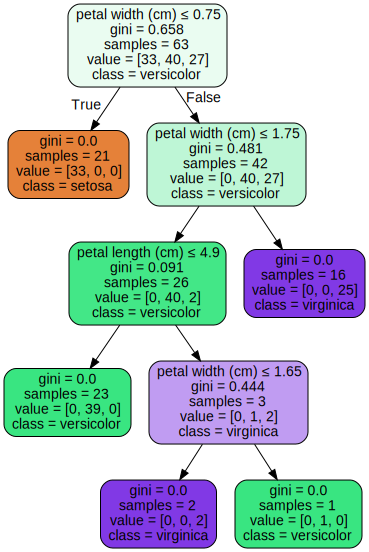

In [320]:
graphs[0]

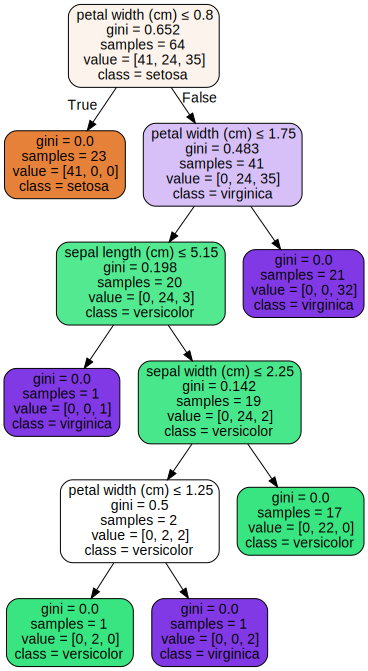

In [321]:
graphs[1]

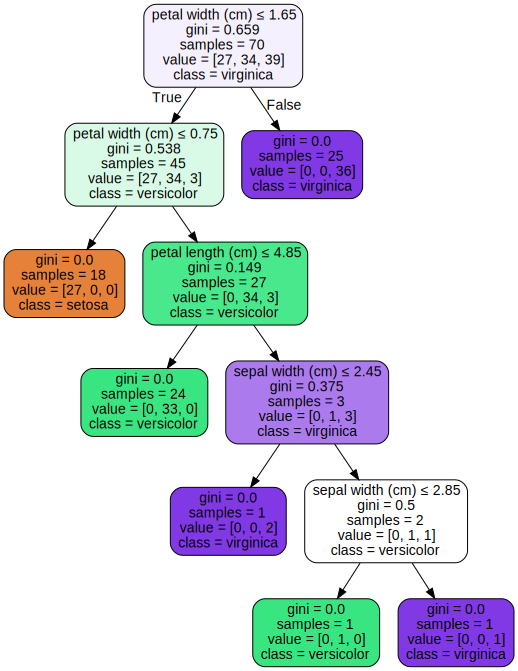

In [322]:
graphs[2]

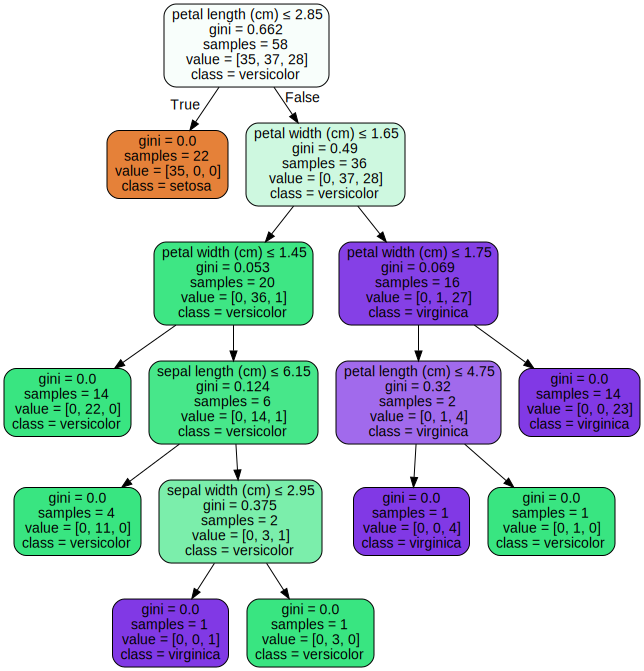

In [323]:
graphs[3]

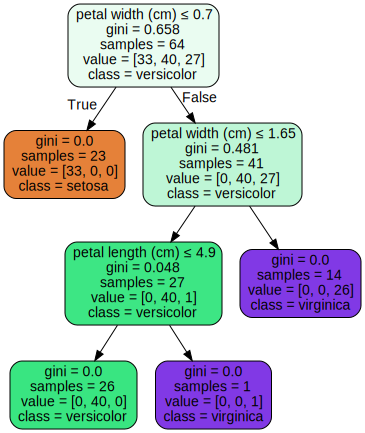

In [324]:
graphs[4]

* <font color='#000080'> We clearly see that we have different decision trees (given that each one have a different random_seed). We show bellow the individual performance of each one using the cross validation to estimate an approximative generalization error :

In [327]:
# Number of cross validation folds
k_folds=5
for counter, t in enumerate(trees, 1):
    cv_err=100*(1-cross_val_score(rf.estimators_[t], iris.data, df["species"], cv=5).mean())
    print("The approximative generalization error of the tree number {counter} is : {err} %".format(err=cv_err,counter=counter))

The approximative generalization error of the tree number 1 is : 3.3333333333333215 %
The approximative generalization error of the tree number 2 is : 4.666666666666663 %
The approximative generalization error of the tree number 3 is : 3.3333333333333215 %
The approximative generalization error of the tree number 4 is : 5.333333333333334 %
The approximative generalization error of the tree number 5 is : 4.666666666666663 %


#### <font color=blue> 3. Study the influence of parameters like max_depth, min_samples_leaf and min_samples_split. Try to optimize them and explain your approach and choices.

<font color='#000080'> As already explained before, the practical effect of those parameters is in on the possibility of generalization, till they are related to the overfitting or underfitting of our model, so as we said early said, our intuition to learn them correctely is throughout the tuning using Cross Validation.
    
**Note** :We need also to add another criterion to the tuning process which is the **Out-of-bag** error to make a better tuning in order to produce better hyperparameters that generalizes well our best seaked model.   

* <font color='#000080'> Learn the hyperparameters **max_depth**, **min_samples_leaf**, **min_samples_split** :

In [378]:
# This code store the cross validation error and the Out-of-bag error of a a given tuple
# (max_depth, min_samples_leaf, min_samples_split) in a dataframe
# The Out-of-bag error is computed on the train data.
max_iter=50
max_depths, min_samples_leafs, min_samples_splits = [1,2,3,4,5],[1,2,3,4,5],[2,3,4,5,6]
a,b,c=np.meshgrid(max_depths, min_samples_leafs, min_samples_splits)
# Initialize the dataframe 
df_hyper = pd.DataFrame(columns=['hyperparameters', "cross validation error", "Out-Bag-Error"])

for max_depth, min_samples_leaf, min_samples_split in zip(a.ravel(), b.ravel(), c.ravel()):
    cv_errors, out_bag_errs=[],[]
    for i in range(max_iter):
        rf_hyper = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=max_depth,min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,oob_score=True)
        # compute the cross validation error
        cv_error=100*(1-cross_val_score(rf_hyper, iris.data, df["species"], cv=5).mean())
        cv_errors.append(cv_error)
        rf_hyper.fit(train.iloc[:,:4], train["species"])
        # compute the Out-Bag error
        out_bag_errs.append((1- rf_hyper.oob_score_)*100)
    triple=[max_depth, min_samples_leaf, min_samples_split]
    # compute the mean cross validation error of the classifier
    out_bag_error=np.array(out_bag_errs).mean()
    # compute the mean cross Out-Bag-Error of the classifier
    cross_val_error=np.array(cv_errors).mean()
    df_hyper = df_hyper.append({'hyperparameters': str(triple), "cross validation error":cross_val_error, "Out-Bag-Error":out_bag_error}, ignore_index=True)
df_hyper.head()

,hyperparameters,cross validation error,Out-Bag-Error
0,"[1, 1, 2]",7.000000,16.037383
1,"[1, 1, 3]",7.906667,15.906542
2,"[1, 1, 4]",7.040000,15.420561
3,"[1, 1, 5]",7.706667,15.420561
4,"[1, 1, 6]",7.893333,14.672897


In [474]:
df_hyper.describe()

,cross validation error,Out-Bag-Error
count,125.000000,125.000000
mean,5.078187,5.484561
std,1.201087,4.946944
min,3.826667,2.766355
25%,4.413333,2.934579
50%,4.546667,3.046729
75%,4.960000,3.364486
max,8.106667,16.878505


<font color='#000080'> As we choosed the minimization of the **cross validation estimated error** and the **Out-Bag-Error** as a criterion to choose th best hyperparameters, we now should choose a way to pick the best hyperparameters set.

* <font color='#000080'> For example, if we prefer the one that minimizes the **Out-Bag-Error** our set of hyperparameters is the one given bellow :

In [492]:
min_Bag_err=df_hyper["Out-Bag-Error"].min()
df_hyper[df_hyper["Out-Bag-Error"]==min_Bag_err]
print("The best hyperparameters in this that minimizes the Out-Bag-Error are :\n max_depth={0}, min_samples_leaf={1}, min_samples_split{2}".format(5,4,4))

The best hyperparameters in this that minimizes the Out-Bag-Error are :
 max_depth=5, min_samples_leaf=4, min_samples_split4


In [493]:
min_Bag_err=df_hyper["cross validation error"].min()
df_hyper[df_hyper["cross validation error"]==min_Bag_err]
print("The best hyperparameters in this that minimizes the Out-Bag-Error are :\n max_depth={0}, min_samples_leaf={1}, min_samples_split{2}".format(4,1,3))

The best hyperparameters in this that minimizes the Out-Bag-Error are :
 max_depth=4, min_samples_leaf=1, min_samples_split3


* <font color='#000080'> The approach we have used is not necessiraly the best, but we are sure that it avoids the overfitting, the main problem when it comes to decision trees. We also saw that it minimizes the generalization error in a good way till it reduced at the same time (but not in a correlated way) the cross validation test error and the Out-Bag-Error too. Thus, those estimated hyperparameters are quite optimal for this given data set.

#### <font color=blue> 4. How is estimated the prediction error of a random forest ? Indication: have a look at parameter oob_score. What are out-of-bag samples ?

* <font color='#000080'>Out-of-bag samples which are not used for training and can be used to testing. Error estimated on these out of bag samples is known as out of bag error. It removes the need for a set aside test set.

#### <font color=blue> 5. What should you do when classes are not balanced in the dataset ? (that is when there are much more examples of one class than another)

* <font color='#000080'> In case of none balanced dataset, we should proceed by botsrapping with replacement using a probability distribution that gives a consistant weight to classes with small number of data points. Once we have set a probability ditribution that gives more weight to less frequent classes, we proceed by botsrapping with replacement from the original data set and each time we pick a data point with a class label we instanciate our probability distribution according to the weight associated to the class, where we put it in the new data set with a probability **the weight of the class** or give it back with a probability the **complementary weight**.    

## Step 5: a small example of regression using random forests
Random forest is capable of learning without carefully crafted data transformations. Take the the $f(x) = \sin(x)$ function for example.

Create some fake data and add a little noise.

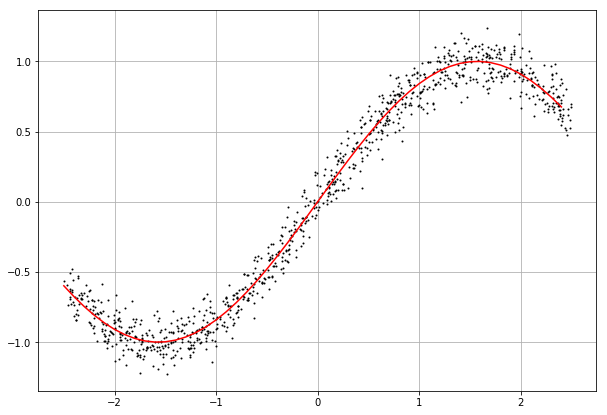

In [219]:
x = np.random.uniform(-2.5, 2.5, 1000)
y = np.sin(x) + np.random.normal(0, .1, 1000)

plt.figure(figsize=(10,7))
plt.plot(x,y,'ko',markersize=1,label='data')
plt.plot(np.arange(-2.5,2.5,0.1),np.sin(np.arange(-2.5,2.5,0.1)),'r-',label='ref')
plt.grid(True)
plt.show()

If we try and build a basic linear model to predict y using x we end up with a straight line that sort of bisects the sin(x) function. Whereas if we use a random forest, it does a much better job of approximating the sin(x) curve and we get something that looks much more like the true function.

Based on this example, we will illustrate how the random forest isn't bound by linear constraints.

## Exercise 4
1. Apply random forests on this dataset for regression and compare performances with ordinary least squares regression.
*Note that ordinay least square regression is available thanks to:
from sklearn.linear_model import LinearRegression*

2. Comment on your results.

### Indications:
You may use half of points for training and others to test predictions. Then you will have an idea of how far the random forest predictor fits the sinus curve.

To this aim, you will need to use the model `RandomForestRegressor`. Be careful that when only 1 feature `x` is used as an input, you will need to reshape it by `x.reshape(-1,1)` when using methods `fit` and `predict`.

#### <font color=blue> 1. Apply random forests on this dataset for regression and compare performances with ordinary least squares regression. Note that ordinay least square regression is available thanks to: from sklearn.linear_model import LinearRegression :

* #### <font color='#000080'> Using Random Forest :

In [244]:
# Creating train and test sets 
train_size=0.5
x=x.reshape(len(x),1)
x_train, y_train = x[:int(train_size*len(x))], y[:int(train_size*len(y))]
x_test, y_test = x[int(train_size*len(x)):], y[int(train_size*len(y)):]

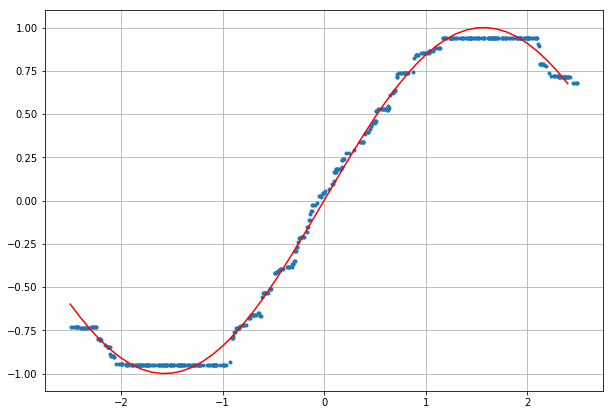

In [245]:
# instanciate the random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=30, max_depth=4)
rf_regressor.fit(x_train, y_train)
y_pred_rf = rf_regressor.predict(x_test)
plt.figure(figsize=(10,7))
plt.plot(x_test, y_pred_rf, '.')
plt.plot(np.arange(-2.5,2.5,0.1),np.sin(np.arange(-2.5,2.5,0.1)),'r-',label='ref')
plt.grid(True)
plt.title("Random Forest prediction plot on the test set")
plt.legend()
plt.show()

In [246]:
from sklearn.metrics import r2_score # The determination coefficient computed to score a regression model

r2 = r2_score(y_pred_rf, y_test)
print("The determination coefficient made by the Random Forest regressor is: r2={} %".format(r2*100))
k_folds=5
scores = cross_val_score(rf_regressor, x, y, scoring='r2', cv=k_folds)
cross_r2=scores.mean()*100
print("The estimated determination coefficient with the cross validation (k_folds={k}) over the data set is : r2={r2} %".format(r2=cross_r2,k=k_folds))

The determination coefficient made by the Random Forest regressor is: r2=97.9047963503551 %
The estimated determination coefficient with the cross validation (k_folds=5) over the data set is : r2=98.05860887725912 %


* #### <font color='#000080'> Using Linear Regression :

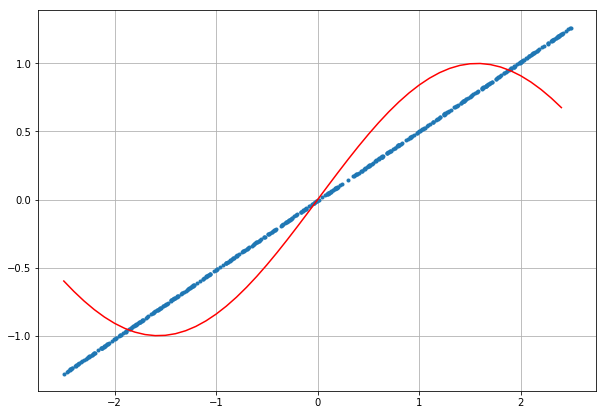

In [247]:
from sklearn.linear_model import LinearRegression

leanr_regressor = LinearRegression()
leanr_regressor.fit(x_train, y_train)

y_pred = leanr_regressor.predict(x_test)
plt.figure(figsize=(10,7))
plt.plot(x_test, y_pred, '.')
plt.grid(True)
plt.title("Linear Regression prediction plot on the test set")
plt.legend()
plt.plot(np.arange(-2.5,2.5,0.1),np.sin(np.arange(-2.5,2.5,0.1)),'r-',label='ref')
plt.show()

In [248]:
# The determination coefficient
r2 = r2_score(y_pred, y_test)
print("The determination coefficient made by the Linear Regression regressor is: r2={} %".format(r2*100))
k_folds=5
scores = cross_val_score(leanr_regressor, x, y, scoring='r2', cv=k_folds)
cross_r2=scores.mean()*100
print("The estimated determination coefficient with the cross validation (k_folds={k}) over the data set is : r2={r2} %".format(r2=cross_r2,k=k_folds))

The determination coefficient made by the Linear Regression regressor is: r2=85.06505146341681 %
The estimated determination coefficient with the cross validation (k_folds=5) over the data set is : r2=85.91418360852984 %


#### <font color=blue> 2. Comment on the results :

<font color='#000080'> The performance of the Random Forest is clearely a way better than the Linear Regression, which is expected because the target function is non linear, which gives an advantage to decision trees and so to the Random Forest. This being said, still the Random Forest won't be able to generalize the learning on to the whole state space. An example to swho that is by taking the trained model and apply it to new data set in the real line (see the example above).


In [377]:
x_val = np.random.uniform(2.5, 7.5, 1000)
y_val= np.sin(x_val) + np.random.normal(0, .1, 1000)
x_val=x_val.reshape(len(x_val),1)
y_pred_val = rf_regressor.predict(x_val)
r2_2 = r2_score(y_pred_val, y_val)
print("r2_2 = ", r2_2*100, "%")

r2_2 =  0.0 %


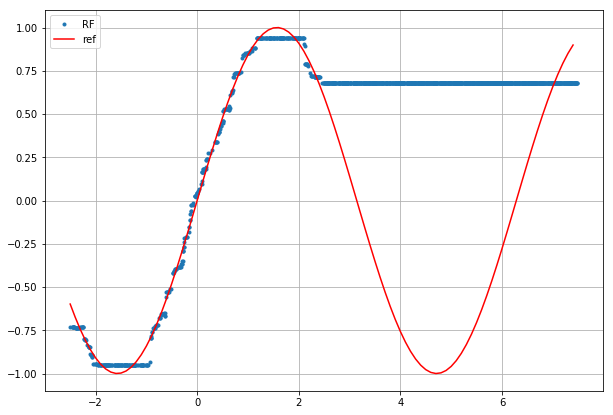

In [369]:
plt.figure(figsize=(10,7))
plt.plot(np.r_[x_test, x_val], np.r_[y_pred_rf, y_pred_val], '.', label="RF")
plt.plot(np.arange(-2.5,7.5,0.1),np.sin(np.arange(-2.5,7.5,0.1)),'r-',label='ref')
plt.legend()
plt.grid(True)
plt.show()

## Pruning trees: not available in scikit-learn.
Since post-pruning of tree is not implemented in scikit-learn, you may think of coding your own pruning function. For instance, taking into account the numer of samples per leaf as proposed below:

In [457]:
# Pruning function (useful ?)
def prune(decisiontree, min_samples_leaf = 1):
    if decisiontree.min_samples_leaf >= min_samples_leaf:
        raise Exception('Tree already more pruned')
    else:
        decisiontree.min_samples_leaf = min_samples_leaf
        tree = decisiontree.tree_
        for i in range(tree.node_count):
            n_samples = tree.n_node_samples[i]
            if n_samples <= min_samples_leaf:
                tree.children_left[i]=-1
                tree.children_right[i]=-1
                

In [458]:
#  tree
pr_clf = tree.DecisionTreeClassifier()
pr_clf = pr_clf.fit(train.iloc[:,:4], y)

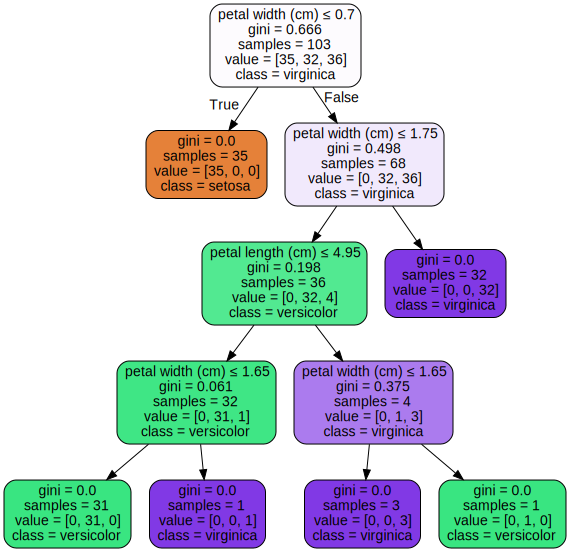

<Figure size 1440x1440 with 0 Axes>

In [450]:
plt.figure(figsize=(20,20))
dot_data = tree.export_graphviz(pr_clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data,format='png')
graph.render('graph_not_pruned')
graph

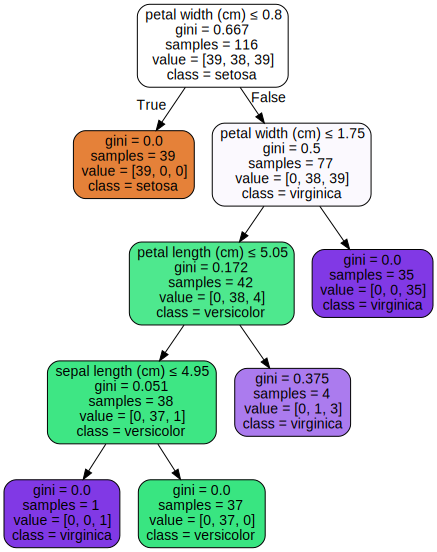

<Figure size 1440x1440 with 0 Axes>

In [459]:
plt.figure(figsize=(20,20))
prune(pr_clf, min_samples_leaf = 10)
dot_data = tree.export_graphviz(pr_clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data,format='png')
graph.render('graph_pruned')
graph

In [460]:
# reset train and test
train, test=set_train_test()

y = train['species']
y_test = test['species']

pruned_classif = pr_clf.fit(train.iloc[:,:4], y)
pruned_score = pruned_classif.score(test.iloc[:,:4],y_test)
print('Accuracy using pruned decision tree :', pruned_score*100,"%")

Accuracy using pruned decision tree : 96.66666666666667 %


<font color='#000080'> Firstly, we see that the tree has been correctly pruned by the algorithm : the tree is less big than the original tree. So the computational time to take a decision with the pruned tree will be lower than for the original tree.
Moreover, the pruning helps us reduce the eventual possibility of overfitting. Indeed, when we set a big value for **min_samples_leaf** the pruning start removing leaves which are giving small gains returns when compared from the top. This way pruning produces a more accurate model when it comes to avoiding the overfitting and kepping the most significant splitting nodes of the decision tree. 